In [428]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [429]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)

In [430]:
# df = pd.read_parquet('cleaned/netflix_parquet')
df = pd.read_parquet('cleaned/netflix_parquet')

Let us take a look at the dataframe we created after joining the movietitles and extracting the release year from the movie titles from the netflix prize dataset. You will notice the use of dictionaries which store the review data per movieId. 

We did this to decrease the memory usage the dataset is using, but also to include more movieids in a smaller sample. One movie contains multiple reviews, so taking more rows of the original dataset which is not grouped by movieId, would mean less different movieIds in a sample to train the recommender system with.

In the code, you will notice many functions/for loops which will unpack the dictionary to get ahold off the stored data.

In [431]:
# look at dataframe, first row and the dictionaries created during joining and merging the netflix prize dataset
df
df.iloc[0]
df['review_data'].iloc[0]

,movieId,year,title,review_data,genres
0,1,2003,Dinosaur Planet,"[{'date': 2005-09-06, 'rating': 3.0, 'userId':...","[Documentary, Animation, Family]"
1,2,2004,Isle of Man TT 2004 Review,"[{'date': 2005-09-05, 'rating': 4.0, 'userId':...",None
2,3,1997,Character,"[{'date': 2003-03-29, 'rating': 4.0, 'userId':...","[Crime, Drama, Mystery]"
3,4,1994,Paula Abdul's Get Up & Dance,"[{'date': 2005-09-06, 'rating': 3.0, 'userId':...",[Family]
4,5,2004,The Rise and Fall of ECW,"[{'date': 2005-02-08, 'rating': 5.0, 'userId':...","[Documentary, Sport]"
...,...,...,...,...,...
1957,1958,2002,WWE: Before They Were Superstars 2,"[{'date': 2005-06-16, 'rating': 2.0, 'userId':...","[Documentary, Sport]"
1958,1959,1961,Splendor in the Grass,"[{'date': 2005-07-07, 'rating': 4.0, 'userId':...","[Drama, Romance]"
1959,1960,2003,Smack: Vol. 1,"[{'date': 2004-09-22, 'rating': 3.0, 'userId':...",None
1960,1961,1939,Port of Shadows,"[{'date': 2005-08-12, 'rating': 3.0, 'userId':...",None


movieId                                                        1
year                                                        2003
title                                            Dinosaur Planet
review_data    [{'date': 2005-09-06, 'rating': 3.0, 'userId':...
genres                          [Documentary, Animation, Family]
Name: 0, dtype: object

array([{'date': datetime.date(2005, 9, 6), 'rating': 3.0, 'userId': '1488844'},
       {'date': datetime.date(2005, 5, 13), 'rating': 5.0, 'userId': '822109'},
       {'date': datetime.date(2005, 10, 19), 'rating': 4.0, 'userId': '885013'},
       {'date': datetime.date(2005, 12, 26), 'rating': 4.0, 'userId': '30878'},
       {'date': datetime.date(2004, 5, 3), 'rating': 3.0, 'userId': '823519'},
       {'date': datetime.date(2005, 11, 17), 'rating': 3.0, 'userId': '893988'},
       {'date': datetime.date(2004, 8, 5), 'rating': 4.0, 'userId': '124105'},
       {'date': datetime.date(2004, 4, 22), 'rating': 3.0, 'userId': '1248029'},
       {'date': datetime.date(2004, 5, 9), 'rating': 4.0, 'userId': '1842128'},
       {'date': datetime.date(2005, 5, 11), 'rating': 3.0, 'userId': '2238063'},
       {'date': datetime.date(2005, 5, 19), 'rating': 4.0, 'userId': '1503895'},
       {'date': datetime.date(2005, 6, 6), 'rating': 5.0, 'userId': '2207774'},
       {'date': datetime.date(2004, 8

So the dataset consists off the id, title, release year and corresponding reviews, where the userId, rating and date are appended in dictionaries. 

### Some general findings about Netflix Prize dataframe:

In [432]:
# Extract all user IDs from the 'review_data' column using list comprehension
user_ids = [review_entry.get('userId') for row in df['review_data'] for review_entry in row if review_entry.get('userId')]

# Count the number of unique users and reviews
unique_users = set(user_ids)
amount_of_reviews = len(user_ids)

# Calculate averages
avg_reviews_per_unique_user = amount_of_reviews / len(unique_users)
avg_reviews_per_movie_id = amount_of_reviews / len(df)

# Print results
print("There are {} reviews in the NETFLIX dataframe.".format(amount_of_reviews))
print("There are {} unique users who have reviewed a movie.".format(len(unique_users)))
print("There are {} movieIds in the NETFLIX dataset.".format(len(df)))
print("A unique user places {} reviews on average in the NETFLIX dataset.".format(round(avg_reviews_per_unique_user)))
print("A movieId receives {} reviews on average in the NETFLIX dataset.".format(round(avg_reviews_per_movie_id)))

There are 9998038 reviews in the NETFLIX dataframe.
There are 447835 unique users who have reviewed a movie.
There are 1962 movieIds in the NETFLIX dataset.
A unique user places 22 reviews on average in the NETFLIX dataset.
A movieId receives 5096 reviews on average in the NETFLIX dataset.


## What sample to take before doing EDA and creating the recommender system:

The complete dataset is handled above, from now on we will work with a representative sample to decrease memory usage and ease of use. The df dataframe will be randomly splitted into multiple samples with different sizes, with replacement(or with duplicates):

### Let's define some functions so we can replicate our work for more samples easily:

In [433]:
import datetime
from scipy.stats import f_oneway

def get_month_name(month_num):
    """
    Convert a numeric month to its corresponding name.

    Parameters:
    month_num (int): Numeric representation of a month (1-12).

    Returns:
    str: Name of the month.
    """
    return datetime.date(1900, month_num, 1).strftime('%B')

# def extract_rating_date_plot_freq(df_list):
#     """
#     Extract ratings data from a list of DataFrames and plot the frequency of ratings per month.

#     Parameters:
#     df_list (list): List of DataFrames containing ratings data.

#     Returns:
#     None
#     """
#     plt.figure(figsize=(20, 12))
#     for idx, df in enumerate(df_list):
#         var_name = [name for name, value in globals().items() if value is df][0]
#         ratings_per_month = {month: 0 for month in range(1, 13)}
#         for row in df['review_data'].values:
#             for entry in row:
#                 month = entry['date'].month
#                 ratings_per_month[month] += 1

#         months = list(ratings_per_month.keys())
#         freq = list(ratings_per_month.values())
    
#         plt.bar(months, freq, alpha=0.5, label=var_name)

#     plt.xlabel('Month')
#     plt.ylabel('Frequency')
#     plt.title('Frequency of Ratings per Month')
#     plt.legend()
#     plt.xticks(range(1, 13), [get_month_name(month) for month in range(1, 13)], rotation=90)  # Rotate x-axis labels
#     plt.tight_layout()  # Adjust layout to prevent overlap
#     plt.show()

def extract_rating_date_plot_freq(df_list):
    """
    Extract ratings data from a list of DataFrames and plot the frequency of ratings per month.

    Parameters:
    df_list (list): List of DataFrames containing ratings data.

    Returns:
    None
    """
    plt.figure(figsize=(20, 12))
    for idx, df in enumerate(df_list):
        var_name = [name for name, value in globals().items() if value is df][0]
        ratings_per_month = {month: 0 for month in range(1, 13)}
        for row in df['review_data'].values:
            for entry in row:
                month = entry['date'].month
                ratings_per_month[month] += 1

        months = list(ratings_per_month.keys())
        freq = list(ratings_per_month.values())
    
        plt.bar(months, freq, alpha=0.5, label=var_name)

        # Add text labels on top of each bar
        for month, f in zip(months, freq):
            plt.text(month, f, str(f), ha='center', va='bottom')

    plt.xlabel('Month')
    plt.ylabel('Frequency')
    plt.title('Frequency of Ratings per Month')
    plt.legend()
    plt.xticks(range(1, 13), [get_month_name(month) for month in range(1, 13)], rotation=90)  # Rotate x-axis labels
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
    
# def extract_count_rating_per_movie_and_plot(df_list, term):
#     """
#     Extract average rating per movie from a list of DataFrames and plot the distribution.

#     Parameters:
#     df_list (list): List of DataFrames containing ratings data.
#     term (str): Term specifying the type of rating to extract (e.g., 'rating', 'usefulness').

#     Returns:
#     None
#     """
#     plt.figure(figsize=(20, 12))
#     for df in df_list:
#         var_name = [name for name, value in globals().items() if value is df][0]
#         avg_ratings = []
#         for row in df['review_data'].values:
#             ratings = [entry[term] for entry in row]
#             avg_rating = len(ratings)
#             avg_ratings.append(avg_rating)  
#         plt.hist(avg_ratings, bins=20, alpha=0.5, label=var_name)  # Adjust the number of bins as needed
#     plt.xlabel('Count of {}'.format(term))
#     plt.ylabel('Frequency')
#     plt.title('Distribution of counts of {} per movie'.format(term))
#     plt.legend()
#     plt.show()

def extract_count_rating_per_movie_and_plot(df_list, term):
    """
    Extract average rating per movie from a list of DataFrames and plot the distribution.

    Parameters:
    df_list (list): List of DataFrames containing ratings data.
    term (str): Term specifying the type of rating to extract (e.g., 'rating', 'usefulness').

    Returns:
    None
    """
    plt.figure(figsize=(20, 12))
    for df in df_list:
        var_name = [name for name, value in globals().items() if value is df][0]
        avg_ratings = []
        for row in df['review_data'].values:
            ratings = [entry[term] for entry in row]
            avg_rating = len(ratings)
            avg_ratings.append(avg_rating)  
        plt.hist(avg_ratings, bins=20, alpha=0.5, label=var_name, density=True)  # Adjust the number of bins as needed
    plt.xlabel('Count of {}'.format(term))
    plt.ylabel('Density')
    plt.title('Distribution of counts of {} per movie'.format(term))
    plt.legend()
    plt.show()
    
from scipy.stats import kruskal

def extract_rating_kruskal_wallis(df_list):
    """
    Perform Kruskal-Wallis test on ratings data from a list of DataFrames.

    Parameters:
    df_list (list): List of DataFrames containing ratings data.

    Returns:
    pandas.DataFrame: DataFrame containing Kruskal-Wallis test results including H-statistic, p-value, and whether to reject the null hypothesis.
    """
    results = []
    for df in df_list:
        var_name = [name for name, value in globals().items() if value is df][0]
        ratings_per_month = {month: [] for month in range(1, 13)}
        total_ratings = 0
        for row in df['review_data'].values:
            for entry in row:
                month = entry['date'].month
                rating = entry['rating']
                ratings_per_month[month].append(entry['rating'])
                total_ratings += 1

        kruskal_data = [ratings_per_month[month] for month in range(1, 13)]
        h_statistic, p_value = kruskal(*kruskal_data)
        results.append({'Sample': var_name, 'H-Statistic': h_statistic, 'P-value': p_value,'Amount of MovieIds':len(df),'Amount of Ratings': total_ratings})

    results_df = pd.DataFrame(results)
    results_df['Reject Null Hypotheses'] = results_df['P-value'] < 0.05

    return results_df

def compare_genre_frequencies(df1, df2):
    """
    Create a frequency plot comparing the genres' frequencies between two dataframes.

    Parameters:
    df1 (DataFrame): First DataFrame containing genres data.
    df2 (DataFrame): Second DataFrame containing genres data.

    Returns:
    None
    """
    # Flatten the lists of genres for both dataframes
    all_genres_df1 = [genre for sublist in df1['genres'] if sublist is not None for genre in sublist]
    all_genres_df2 = [genre for sublist in df2['genres'] if sublist is not None for genre in sublist]

    # Count the frequencies of genres in both dataframes
    genre_counts_df1 = {genre: all_genres_df1.count(genre) for genre in set(all_genres_df1)}
    genre_counts_df2 = {genre: all_genres_df2.count(genre) for genre in set(all_genres_df2)}

    # Plot the frequencies
    plt.figure(figsize=(10, 6))  # Set figure size for better visualization
    plt.bar(genre_counts_df1.keys(), genre_counts_df1.values(), alpha=0.5, label='Sample DF')
    plt.bar(genre_counts_df2.keys(), genre_counts_df2.values(), alpha=0.5, label='DF')
    plt.figure(figsize=(20, 12))
    plt.xlabel('Genre')
    plt.ylabel('Frequency')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# def compare_genre_frequencies(df1, df2):
#     """
#     Compare the frequencies of genres between two dataframes and plot the results.

#     Parameters:
#     df1 (DataFrame): First DataFrame containing genres data.
#     df2 (DataFrame): Second DataFrame containing genres data.

#     Returns:
#     None
#     """
#     # Flatten the lists of genres for both dataframes, skipping None values
#     all_genres_df1 = [genre for sublist in df1['genres'] if sublist is not None for genre in sublist]
#     all_genres_df2 = [genre for sublist in df2['genres'] if sublist is not None for genre in sublist]

#     # Count the frequencies of genres in both dataframes
#     genre_counts_df1 = {genre: all_genres_df1.count(genre) for genre in set(all_genres_df1)}
#     genre_counts_df2 = {genre: all_genres_df2.count(genre) for genre in set(all_genres_df2)}

#     # Plot the genre frequencies
#     plt.figure(figsize=(20, 12))  # Set the figure size
#     plt.bar(genre_counts_df1.keys(), genre_counts_df1.values(), alpha=0.5, label='Sample DF')
#     plt.bar(genre_counts_df2.keys(), genre_counts_df2.values(), alpha=0.5, label='DF')

#     # Add text labels on top of each bar
#     for genre, freq in genre_counts_df1.items():
#         plt.text(genre, freq, str(freq), ha='center', va='bottom', rotation=90)
#     for genre, freq in genre_counts_df2.items():
#         plt.text(genre, freq, str(freq), ha='center', va='bottom', rotation=90)

#     plt.xlabel('Genre')
#     plt.ylabel('Frequency')
#     plt.title('Comparison of Genre Frequencies')
#     plt.legend()
#     plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
#     plt.tight_layout()  # Adjust layout to prevent overlap
#     plt.show()
    
def compare_genre_frequencies(df1, df2):
    """
    Compare the frequencies of genres between two dataframes and plot the results.

    Parameters:
    df1 (DataFrame): First DataFrame containing genres data.
    df2 (DataFrame): Second DataFrame containing genres data.

    Returns:
    None
    """
    # Flatten the lists of genres for both dataframes, skipping None values
    all_genres_df1 = [genre for sublist in df1['genres'] if sublist is not None for genre in sublist]
    all_genres_df2 = [genre for sublist in df2['genres'] if sublist is not None for genre in sublist]

    # Count the frequencies of genres in both dataframes
    genre_counts_df1 = {genre: all_genres_df1.count(genre) for genre in set(all_genres_df1)}
    genre_counts_df2 = {genre: all_genres_df2.count(genre) for genre in set(all_genres_df2)}

    # Sort genre counts dictionaries by frequency in descending order
    genre_counts_df1_sorted = dict(sorted(genre_counts_df1.items(), key=lambda item: item[1], reverse=True))
    genre_counts_df2_sorted = dict(sorted(genre_counts_df2.items(), key=lambda item: item[1], reverse=True))

    # Plot the genre frequencies
    plt.figure(figsize=(20, 12))  # Set the figure size
    plt.bar(genre_counts_df1_sorted.keys(), genre_counts_df1_sorted.values(), alpha=0.5, label='Sample DF')
    plt.bar(genre_counts_df2_sorted.keys(), genre_counts_df2_sorted.values(), alpha=0.5, label='DF')

    # Add text labels on top of each bar
    for genre, freq in genre_counts_df1_sorted.items():
        plt.text(genre, freq, str(freq), ha='center', va='bottom', rotation=90)
    for genre, freq in genre_counts_df2_sorted.items():
        plt.text(genre, freq, str(freq), ha='center', va='bottom', rotation=90)

    plt.xlabel('Genre')
    plt.ylabel('Frequency')
    plt.title('Comparison of Genre Frequencies')
    plt.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    from scipy.stats import chi2_contingency

def check_sample_representative(sample_counts, population_counts):
    """
    Perform a chi-square test for independence to check if a sample is representative of the population.

    Parameters:
    sample_counts (dict): Dictionary containing counts of categories in the sample.
    population_counts (dict): Dictionary containing counts of categories in the entire population.

    Returns:
    float: The p-value from the chi-square test.
    bool: True if the sample is representative, False otherwise based on the p-value threshold (e.g., 0.05).
    """
    # Convert dictionaries to lists of counts
    sample_values = list(sample_counts.values())
    population_values = list(population_counts.values())

    # Perform chi-square test for independence
    _, p_value, _, _ = chi2_contingency([sample_values, population_values])

    # Define significance level
    alpha = 0.05

    # Check if the p-value is less than the significance level
    is_representative = p_value >= alpha

    return p_value, is_representative

* # Insert explanation about taking sample

In [438]:
import random

sampled_df = df[df.columns]

# Step 1: Count the number of dictionaries per row in the review_data column
sampled_df['num_reviews'] = sampled_df['review_data'].apply(lambda x: len(x))

# Step 2: Divide the dataset into strata based on the number of reviews for each movie
quintiles = sampled_df['num_reviews'].quantile([0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.75, 1.0])
# Adjust the boundaries to include fewer movies with a large number of reviews
stratum_boundaries = [0, quintiles[0.125], quintiles[0.25], quintiles[1.0]]
stratum_labels = ['Q1', 'Q2', 'Q3-Q4-Q5-Q6-Q7']

# Create a new column to categorize movies into strata based on the number of reviews
sampled_df['review_stratum'] = pd.cut(sampled_df['num_reviews'], bins=stratum_boundaries, labels=stratum_labels)

# Step 3: Define sample size per stratum
sample_size_per_stratum = 20

# Step 4: Within each stratum, apply random sampling techniques to select movies
sampled_movies = []

# Iterate over each stratum
for stratum in sampled_df['review_stratum'].dropna().unique():  # Drop NaN values
    # Filter movies in the current stratum
    stratum_movies = sampled_df[sampled_df['review_stratum'] == stratum]
    
    # Apply simple random sampling to select movies within the stratum
    sampled_indices = random.sample(list(stratum_movies.index), sample_size_per_stratum)
    sampled_movies.extend(sampled_indices)

# Step 5: Create the sampled DataFrame
sampled_df = sampled_df.loc[sampled_movies, ['movieId', 'review_data', 'genres', 'year', 'title', 'review_stratum','num_reviews']]

# Print the sampled DataFrame
sampled_df

,movieId,review_data,genres,year,title,review_stratum,num_reviews
1748,1749,"[{'date': 2005-07-16, 'rating': 3.0, 'userId':...","[Romance, Western]",1947,Angel and the Badman,Q3-Q4-Q5-Q6-Q7,1319
434,435,"[{'date': 2004-10-02, 'rating': 3.0, 'userId':...","[Comedy, Romance]",1996,Love Can Seriously Damage Your Health,Q3-Q4-Q5-Q6-Q7,343
1734,1735,"[{'date': 2003-10-06, 'rating': 5.0, 'userId':...","[Documentary, Short]",1974,Amarcord,Q3-Q4-Q5-Q6-Q7,4115
1392,1393,"[{'date': 2002-12-31, 'rating': 4.0, 'userId':...","[Crime, Sci-Fi, Thriller]",1998,Mr. Murder,Q3-Q4-Q5-Q6-Q7,245
1718,1719,"[{'date': 2005-07-05, 'rating': 5.0, 'userId':...","[Action, Adventure, Comedy, Drama, Romance]",2004,The Life Aquatic with Steve Zissou,Q3-Q4-Q5-Q6-Q7,58364
197,198,"[{'date': 2002-11-27, 'rating': 2.0, 'userId':...","[Action, Crime, Mystery, Romance, Thriller]",1997,Gupt,Q3-Q4-Q5-Q6-Q7,194
1584,1585,"[{'date': 2005-07-05, 'rating': 5.0, 'userId':...","[Mystery, Thriller]",2001,Joy Ride,Q3-Q4-Q5-Q6-Q7,21359
1814,1815,"[{'date': 2005-08-13, 'rating': 5.0, 'userId':...","[Comedy, Drama, Romance]",1979,Camera Buff,Q3-Q4-Q5-Q6-Q7,199
1065,1066,"[{'date': 2005-07-08, 'rating': 3.0, 'userId':...","[Action, Adventure, Drama, Sci-Fi]",1978,Superman: The Movie,Q3-Q4-Q5-Q6-Q7,34941
1740,1741,"[{'date': 2005-12-06, 'rating': 4.0, 'userId':...",None,1999,Cowboy Bebop Remix,Q3-Q4-Q5-Q6-Q7,10605


### Compare some key EDA findings to see wether the samples are representative:

Most column distributions were highly skewed, which indicates that it is not promising to compare that for multiple samples, as the result will be very likely to be the same. Results such as the normality of ratings and the anova results are most important. We will look at those for different samples:

,Sample,H-Statistic,P-value,Amount of MovieIds,Amount of Ratings,Reject Null Hypotheses
0,sampled_df,1081.069084,6.781157e-225,60,177129,True
1,df,5622.156250,0.000000e+00,1962,9998038,True


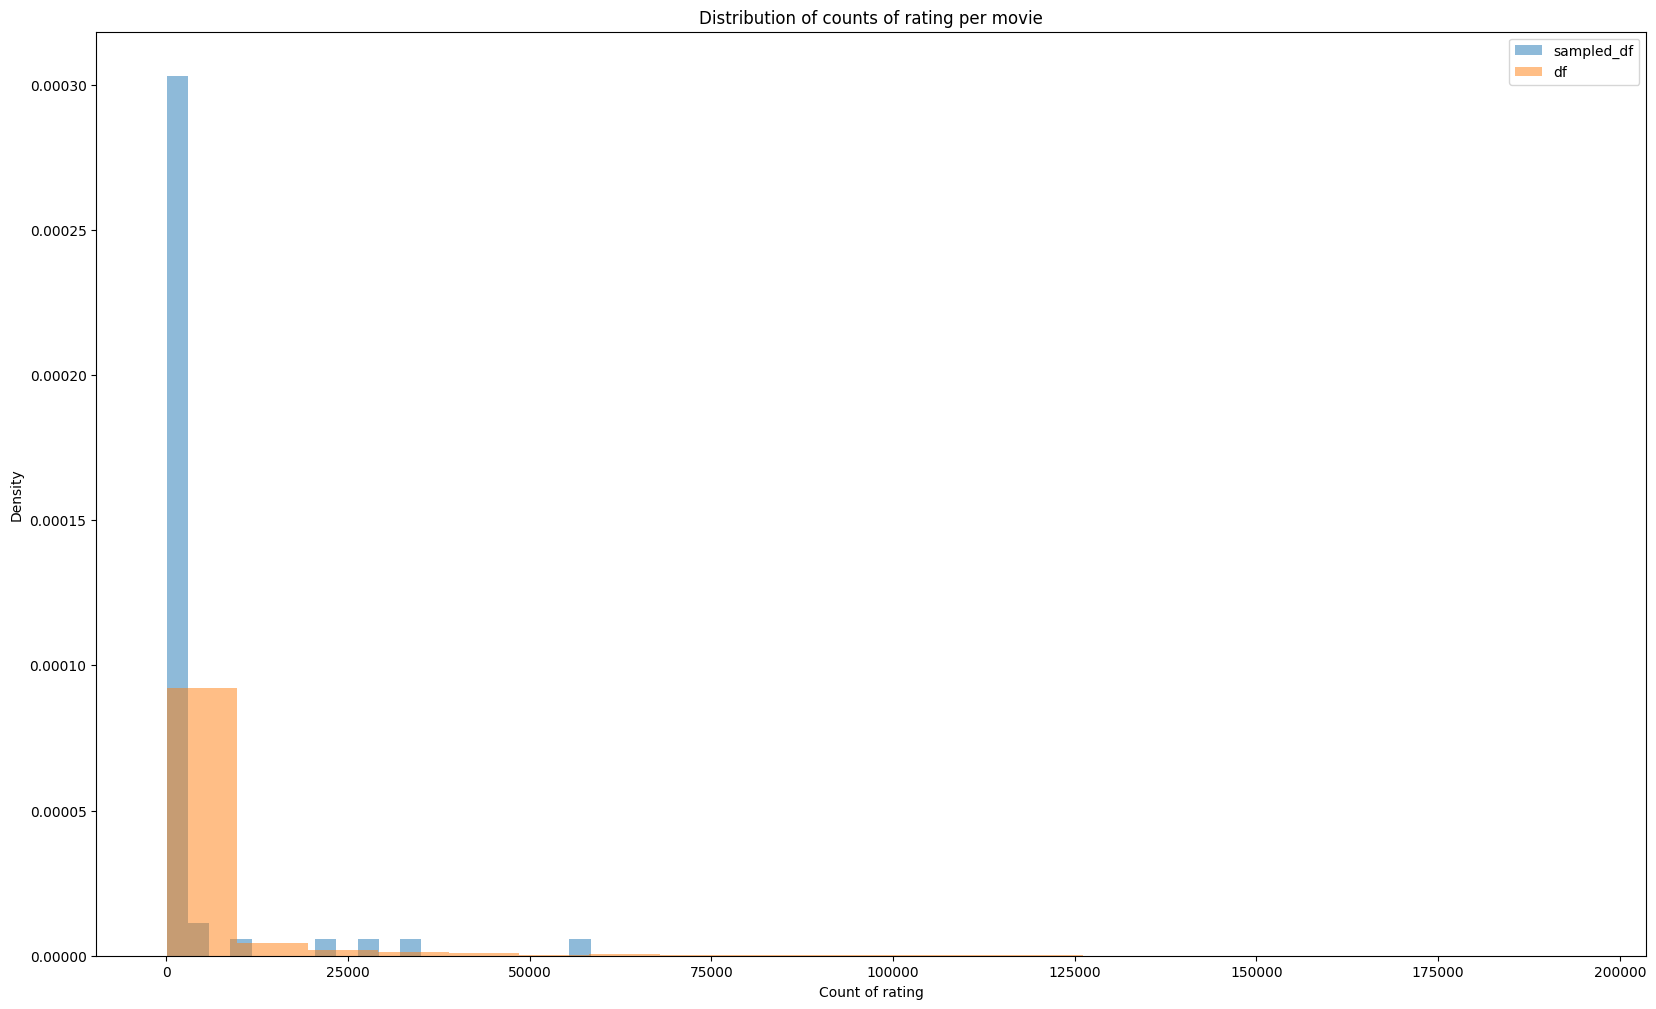

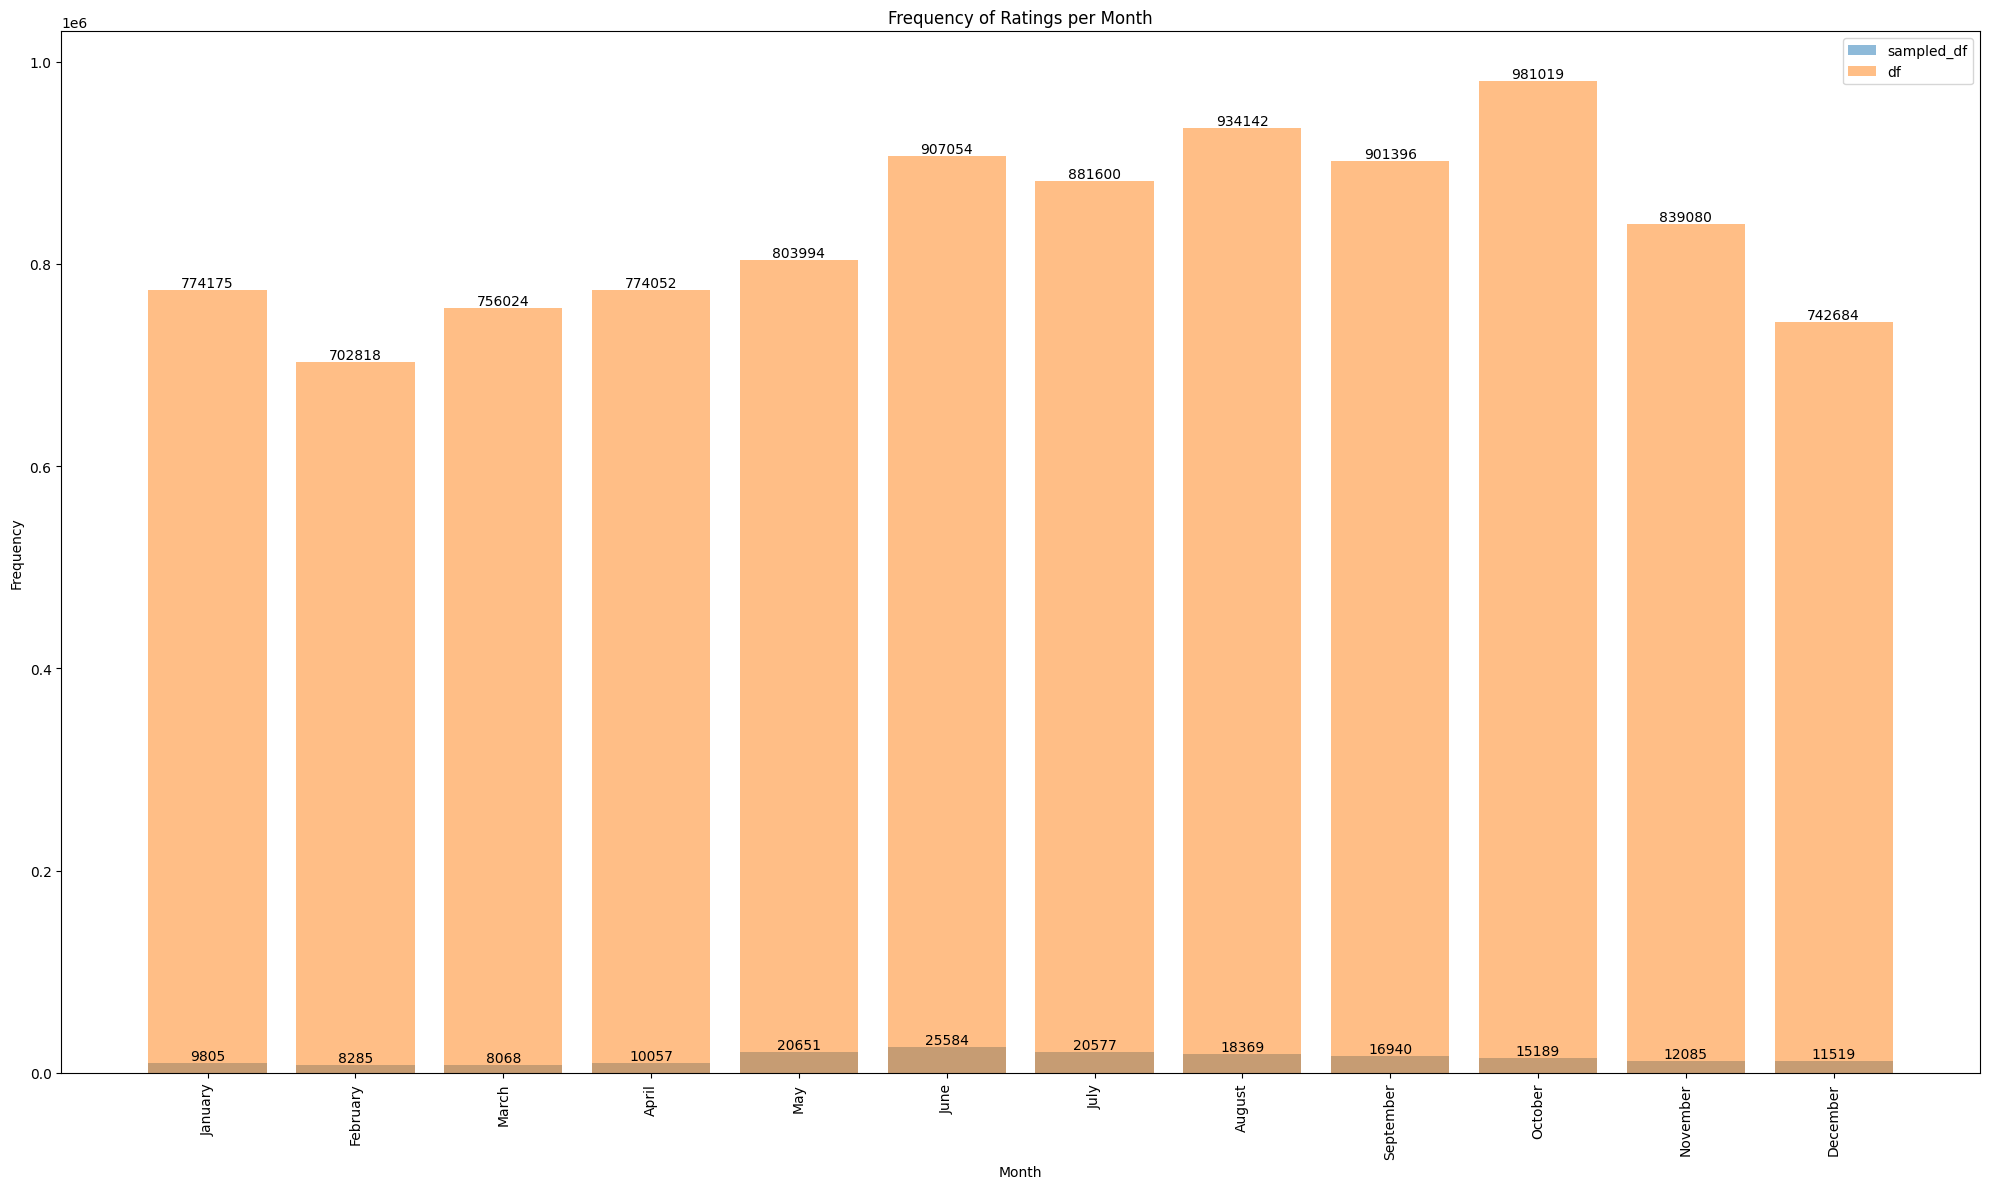

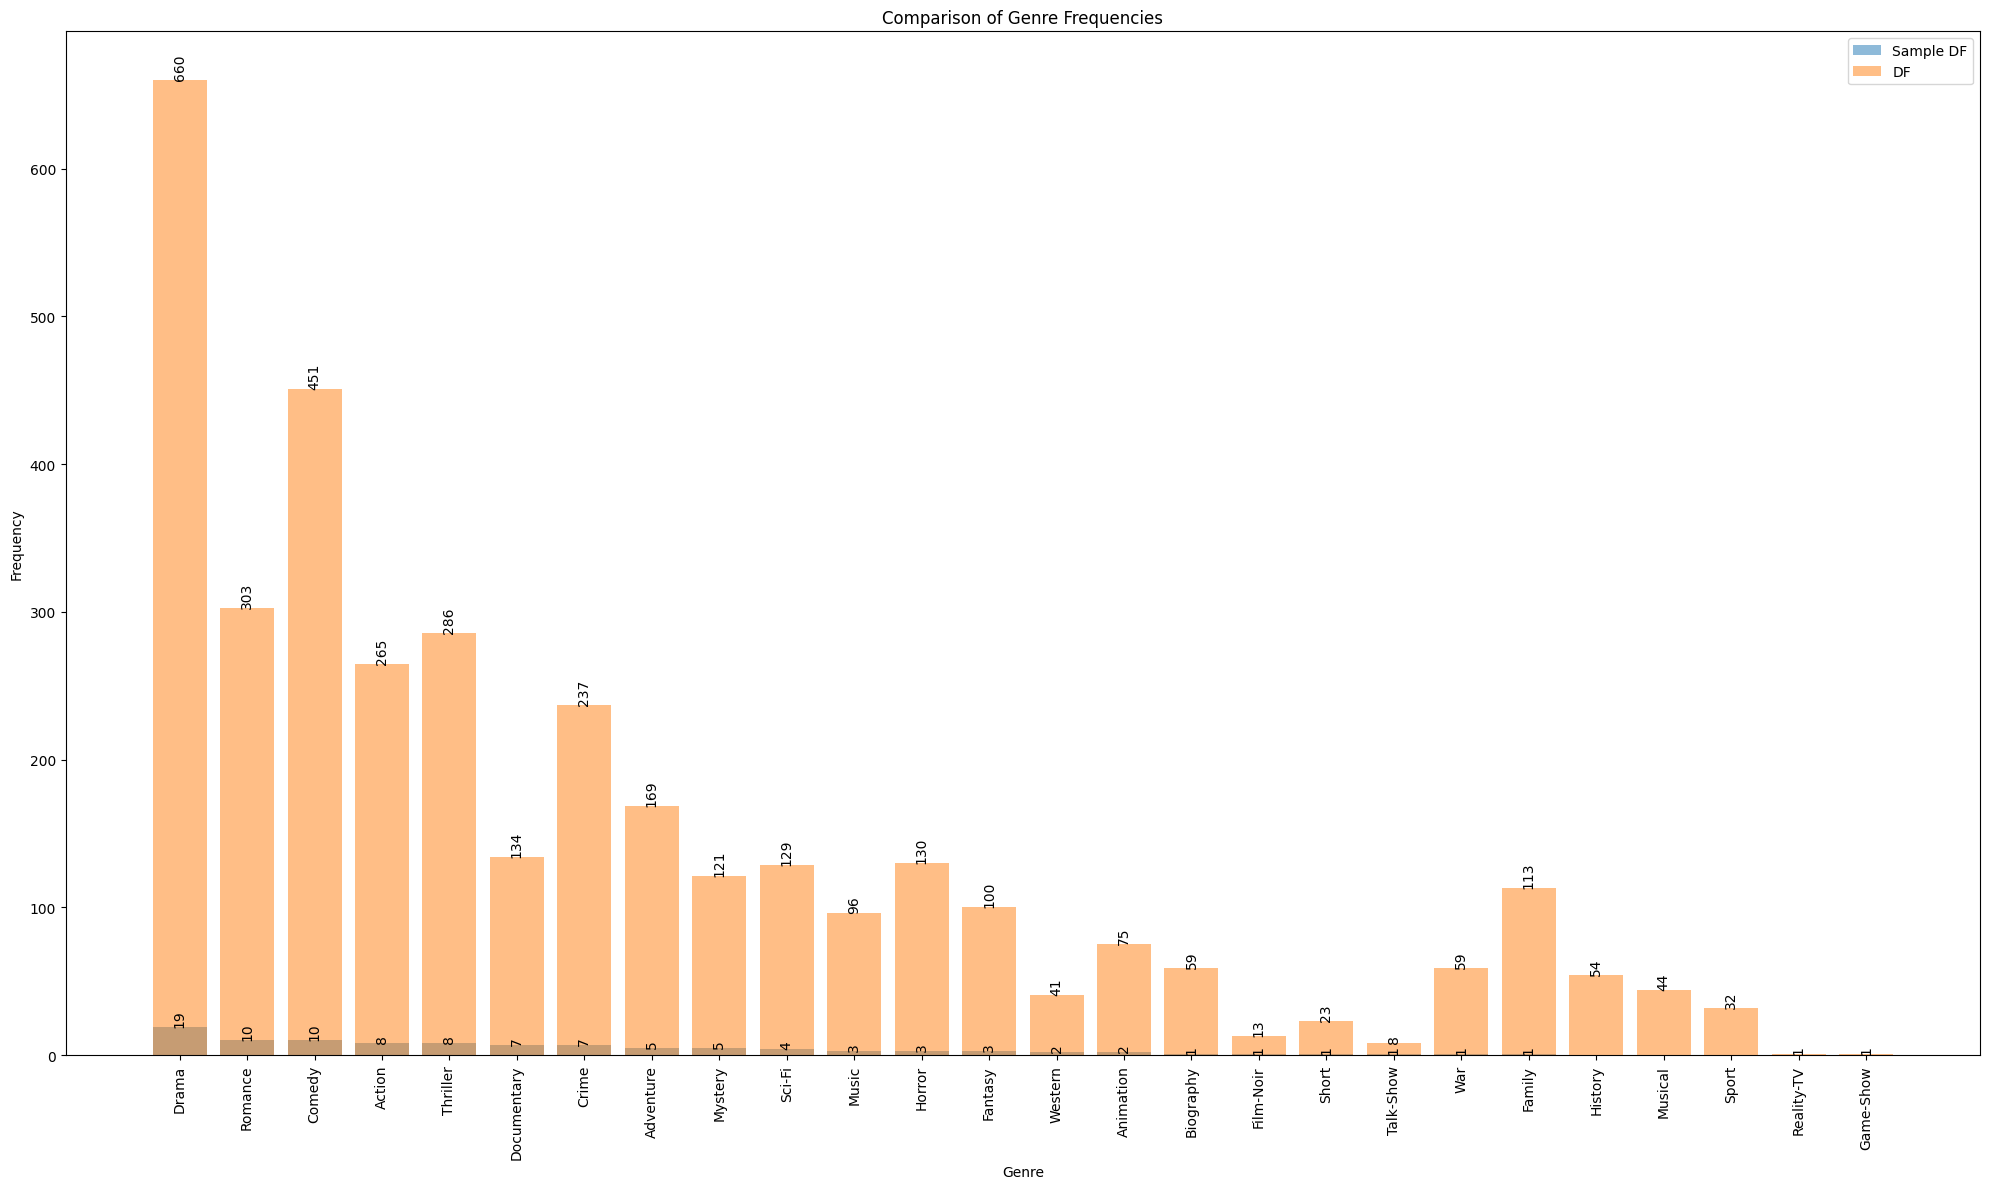

In [439]:
df_list = [sampled_df,df]
extract_rating_kruskal_wallis(df_list)
extract_count_rating_per_movie_and_plot(df_list,'rating')
extract_rating_date_plot_freq(df_list)  
compare_genre_frequencies(sampled_df, df)

In [444]:
from scipy.stats import ttest_ind

# Define the strata
strata = sampled_df['review_stratum'].unique()

# Perform t-test for each stratum
for stratum in strata:
    # Extract data for the current stratum from both sample and population
    sample_data = sampled_df[sampled_df['review_stratum'] == sampled_df]['num_reviews']
    population_data = df[df['review_stratum'] == stratum]['num_reviews']
    
    # Calculate the mean for each group
    sample_mean = sample_data.mean()
    population_mean = population_data.mean()
    
    # Perform the t-test
    t_statistic, p_value = ttest_ind(sample_data, population_data)
    
    # Print the results
    print(f"Stratum: {stratum}")
    print(f"Sample Mean: {sample_mean}")
    print(f"Population Mean: {population_mean}")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    
    # Interpret the results
    if p_value < 0.05:
        print("The sample mean is statistically significantly different from the population mean.")
    else:
        print("The sample mean is not statistically significantly different from the population mean.")
    print()

,movieId,review_data,genres,year,title,review_stratum,num_reviews
1748,1749,"[{'date': 2005-07-16, 'rating': 3.0, 'userId':...","[Romance, Western]",1947,Angel and the Badman,Q3-Q4-Q5-Q6-Q7,1319
434,435,"[{'date': 2004-10-02, 'rating': 3.0, 'userId':...","[Comedy, Romance]",1996,Love Can Seriously Damage Your Health,Q3-Q4-Q5-Q6-Q7,343
1734,1735,"[{'date': 2003-10-06, 'rating': 5.0, 'userId':...","[Documentary, Short]",1974,Amarcord,Q3-Q4-Q5-Q6-Q7,4115
1392,1393,"[{'date': 2002-12-31, 'rating': 4.0, 'userId':...","[Crime, Sci-Fi, Thriller]",1998,Mr. Murder,Q3-Q4-Q5-Q6-Q7,245
1718,1719,"[{'date': 2005-07-05, 'rating': 5.0, 'userId':...","[Action, Adventure, Comedy, Drama, Romance]",2004,The Life Aquatic with Steve Zissou,Q3-Q4-Q5-Q6-Q7,58364
197,198,"[{'date': 2002-11-27, 'rating': 2.0, 'userId':...","[Action, Crime, Mystery, Romance, Thriller]",1997,Gupt,Q3-Q4-Q5-Q6-Q7,194
1584,1585,"[{'date': 2005-07-05, 'rating': 5.0, 'userId':...","[Mystery, Thriller]",2001,Joy Ride,Q3-Q4-Q5-Q6-Q7,21359
1814,1815,"[{'date': 2005-08-13, 'rating': 5.0, 'userId':...","[Comedy, Drama, Romance]",1979,Camera Buff,Q3-Q4-Q5-Q6-Q7,199
1065,1066,"[{'date': 2005-07-08, 'rating': 3.0, 'userId':...","[Action, Adventure, Drama, Sci-Fi]",1978,Superman: The Movie,Q3-Q4-Q5-Q6-Q7,34941
1740,1741,"[{'date': 2005-12-06, 'rating': 4.0, 'userId':...",None,1999,Cowboy Bebop Remix,Q3-Q4-Q5-Q6-Q7,10605


# **add conclusion about sampled df**

### Overall conclusion:

Most important EDA findings do not seem to change when you increase or decrease the sample size. At the same time, ANOVA results of each sample showed that only a couple of sample sizes are suitable to highlight differences across groups. Those sample sizes can be considered to feed to the recommender system to train.

## Let's look into the columns more deeply:
### When were the most movies released?

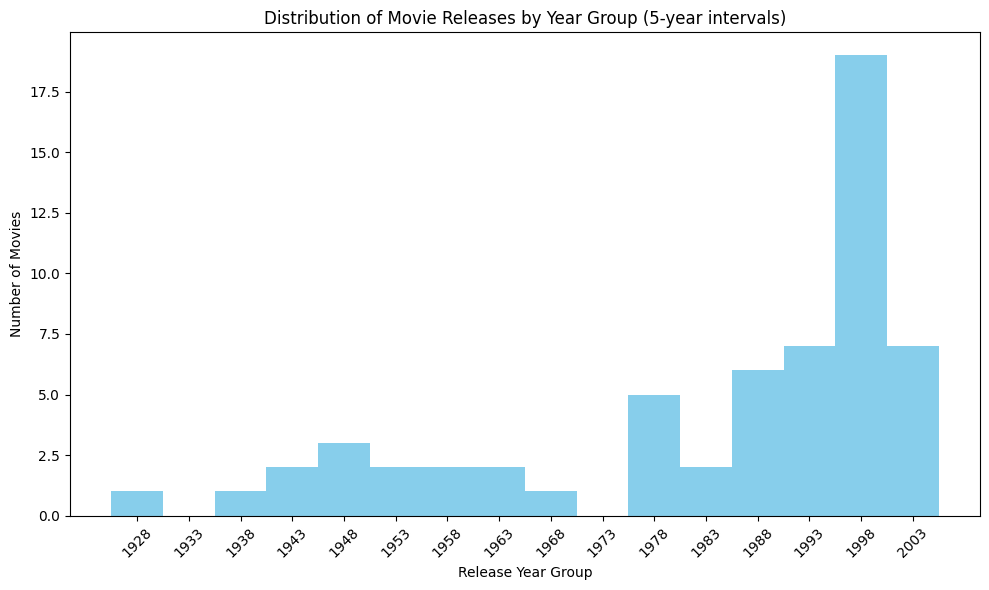

In [ ]:
# Define the bin size in years
bin_size = 5

# Extract release years from the 'release_year' column
release_years = (sampled_df['year'].astype(int)).tolist()

# Calculate the minimum and maximum release years to determine the range
min_year = min(release_years)
max_year = max(release_years)

# Initialize dictionary to store counts for each bin
bin_counts = {}

# Count the occurrences of each release year within the corresponding bin
for year in release_years:
    bin_index = (year - min_year) // bin_size
    bin_start_year = min_year + bin_index * bin_size
    if bin_start_year in bin_counts:
        bin_counts[bin_start_year] += 1
    else:
        bin_counts[bin_start_year] = 1

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(bin_counts.keys(), bin_counts.values(), color='skyblue', width=bin_size)
plt.xlabel('Release Year Group')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Releases by Year Group ({}-year intervals)'.format(bin_size))
plt.xticks(range(min_year, max_year + 1, bin_size), rotation=45)
plt.tight_layout()
plt.show(); # to dont export text output

Seems like most movies have been released around the 90s and the 00s in the dataset.

### When were the most ratings placed?

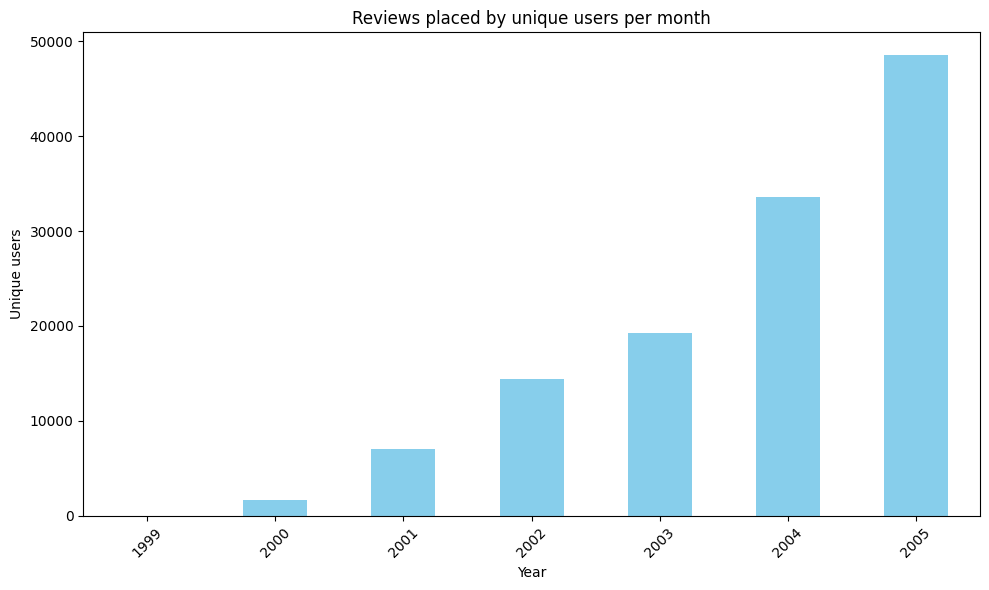

In [ ]:
# Extract review dates and user IDs using NumPy
review_data = sampled_df['review_data'].values
review_dates = np.concatenate([np.array([entry['date'] for entry in row]) for row in review_data])
user_ids = np.concatenate([np.array([entry['userId'] for entry in row]) for row in review_data])

# Convert review_dates to pandas datetime objects
review_dates = pd.to_datetime(review_dates)

# Create a DataFrame with review dates and user IDs
review_df = pd.DataFrame({'Date': review_dates, 'User_ID': user_ids})

# Group reviews by month and count the number of unique users for each month
yearly_unique_users = review_df.groupby(review_df['Date'].dt.to_period('Y'))['User_ID'].nunique()

# Plot the number of unique users by month
plt.figure(figsize=(10, 6))
yearly_unique_users.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Unique users')
plt.title('Reviews placed by unique users per month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

In 2005, most movies were reviewed by unique users.

### On which days of the week most reviews were placed?

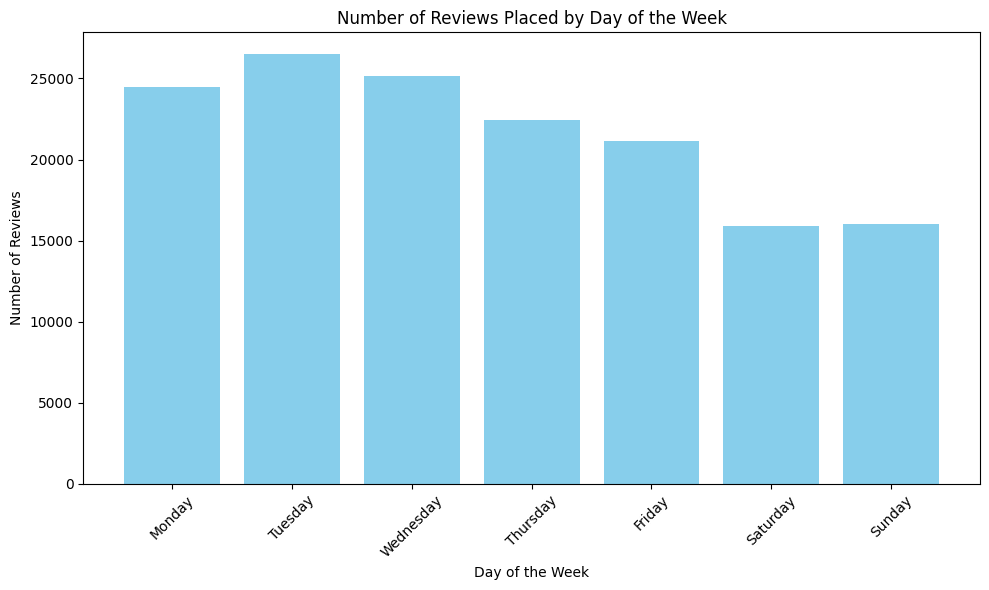

In [ ]:
# Get the weekday (0: Monday, 1: Tuesday, ..., 6: Sunday)
weekdays = review_df['Date'].dt.dayofweek

# Count the occurrences of each weekday
weekday_counts = np.bincount(weekdays)

# Plot the distribution of reviews by day of the week
plt.figure(figsize=(10, 6))
plt.bar(range(7), weekday_counts, color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Placed by Day of the Week')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.tight_layout()
plt.show();

Most reviews were made on Tuesdays.

### Which movie has the highest average rating?

In [ ]:
# extract review dates, user IDs, and ratings using NumPy
review_data = sampled_df['review_data'].values
review_dates = np.concatenate([np.array([entry['date'] for entry in row]) for row in review_data])
user_ids = np.concatenate([np.array([entry['userId'] for entry in row]) for row in review_data])
ratings = np.concatenate([np.array([entry['rating'] for entry in row]) for row in review_data])

# Convert review_dates to pandas datetime objects
review_dates = pd.to_datetime(review_dates)

# Extract movie titles
titles = np.concatenate([[title] * len(row) for title, row in zip(sampled_df['title'], review_data)])

# Create a DataFrame with review dates, user IDs, ratings, and movie titles
review_df = pd.DataFrame({'Date': review_dates, 'User_ID': user_ids, 'Rating': ratings, 'Movie_Title': titles})

In [ ]:
review_df.groupby('Movie_Title')['Rating'].mean().sort_values(ascending=False).head(10)
print('{} is the best rated movie on average in this sample.'.format(review_df.groupby('Movie_Title')['Rating'].mean().idxmax()))

Movie_Title
Seven Samurai                            4.199615
The Battle of Algiers: Bonus Material    3.915385
Sherlock Holmes: The Scarlet Claw        3.847291
Midsomer Murders: Blood Will Out         3.831492
Fight Club: Bonus Material               3.816817
Operation Pacific                        3.762915
The Life and Times of Hank Greenberg     3.644394
Fela: Music Is the Weapon                3.582524
Untamed Heart                            3.555412
Love in the Afternoon                    3.540506
Name: Rating, dtype: float64

Seven Samurai is the best rated movie on average in this sample.


In [ ]:
# see which movie has received the most amount of reviews and how many unique users have reviewed a movie
review_df['Movie_Title'].value_counts().head(10)
print('{} has received the highest amount of reviews in this sample.'.format(review_df['Movie_Title'].value_counts().idxmax()))
review_df.groupby('Movie_Title')['User_ID'].nunique().sort_values(ascending=False).head(10)
print('Above, the unique users that gave a review per movie is computed. The values match up exactly with the amount of reviews per movie, indicating no user has reviewed a movie twice.')

Movie_Title
The Perfect Storm                72381
Seven Samurai                    31691
Untamed Heart                    10043
Rocky V                           8170
Defending Your Life               7925
Love in the Afternoon             2370
The Pope of Greenwich Village     1932
Operation Pacific                 1839
The Best of Designing Women       1395
Fight Club: Bonus Material        1332
Name: count, dtype: int64

The Perfect Storm has received the highest amount of reviews in this sample.


Movie_Title
The Perfect Storm                72381
Seven Samurai                    31691
Untamed Heart                    10043
Rocky V                           8170
Defending Your Life               7925
Love in the Afternoon             2370
The Pope of Greenwich Village     1932
Operation Pacific                 1839
The Best of Designing Women       1395
Fight Club: Bonus Material        1332
Name: User_ID, dtype: int64

Above, the unique users that gave a review per movie is computed. The values match up exactly with the amount of reviews per movie, indicating no user has reviewed a movie twice.


### Handle outliers/distributions:

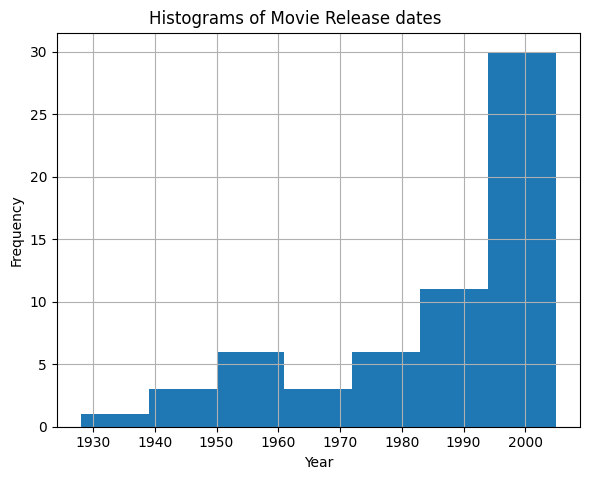

In [ ]:
# Plot histogram with bins spanning 10 years
sampled_df['year'] = sampled_df['year'].astype(int)
plt.figure(figsize=(6, 5))
sampled_df['year'].hist(bins=int((sampled_df['year'].max() - sampled_df['year'].min()) / 10), figsize=(6, 5))
plt.suptitle('Histograms of Movie Release dates', y=0.95)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show();

Data is skewed, as most records are released during the 90s and 00s.

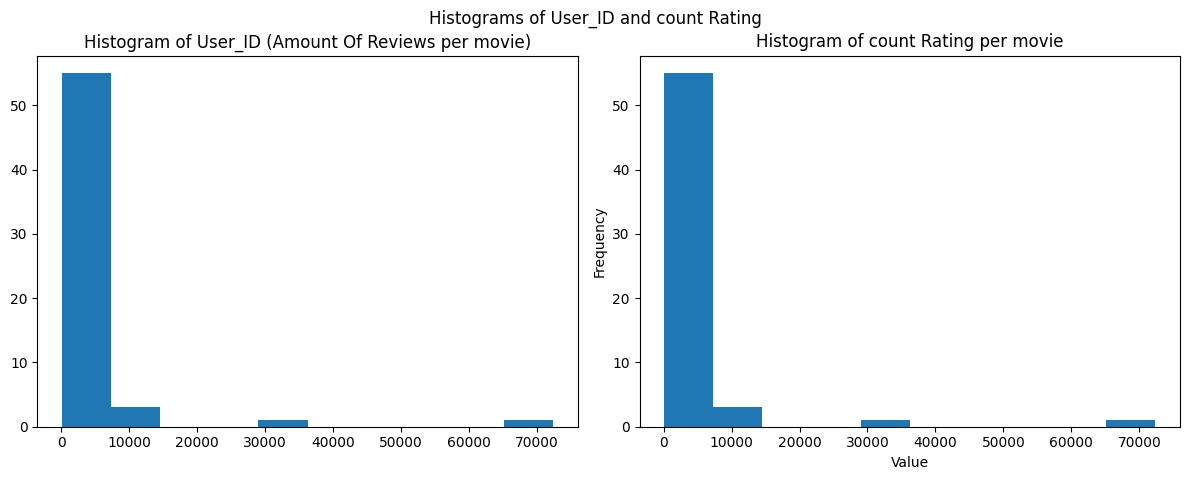

In [ ]:
# Group by 'Movie_Title' and calculate count of User_ID and mean of Rating
result_df = review_df.groupby('Movie_Title').agg({'User_ID': 'count', 'Rating': 'count'}).reset_index()

# Plot histograms for 'User_ID' and 'Rating'
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for 'User_ID'
axs[0].hist(result_df['User_ID'])
axs[0].set_title('Histogram of User_ID (Amount Of Reviews per movie)')

# Histogram for 'Rating'
axs[1].hist(result_df['Rating'])
axs[1].set_title('Histogram of count Rating per movie')

# Setting common attributes
plt.suptitle('Histograms of User_ID and count Rating', y=0.95)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show();

Amount of reviews per movieId is skewed, avg rating per movie seems approx. normally distributed.

In [ ]:
result_df

,Movie_Title,User_ID,Rating
0,A Fishy Story,126,126
1,Antarctica: IMAX,1249,1249
2,Baby Genius: Mozart and Friends,92,92
3,Blue's Clues: Blue's Room: It's Hug Day,184,184
4,Butch and Sundance: The Early Days,95,95
5,Cavalry Charge,138,138
6,Chained Girls / Daughters of Lesbos: Double Fe...,146,146
7,Class of Nuke 'Em High 2,95,95
8,Classic Country Comedy,143,143
9,Crash Dive,184,184


Amount of reviews is highly skewed, indicating lots of movies with low amounts to no reviews.

AVG Rating is normally distributed, meaning the ratings across movies in the dataset are normally deviating around the mean.

### **Outliers**

Outliers in amount of reviews and release date will not be removed, as they represent users connected to those movies. Those represent a real-world variability which cannot be excluded. 

Furthermore, robust recommender systems should be able to adapt to these outliers and represent valuable information to those users as well. Removing this information would also mean that the model cannot be trained on those.

As the user-item matrix will be sparse, removing outliers would further reduce the size of the data which the model can use to train, which would make it more challenging to build a reliable recommender system.

## Check for association with time and ratings:

Hypothese before doing ANOVA:

- **H0**: means of groups across months of the year are **equal**, meaning there **IS NO** correlation between the time of the year and the avg. rating.
- **Ha**: means of groups across months of the year are **NOT equal**, meaning there **IS** correlation between the time of the year and the avg. rating.

In [ ]:
# force data into category format and change to month notation to compare months with avg rating
df_anova = review_df[['Date', 'User_ID', 'Rating', 'Movie_Title']]
df_anova['Date'] = (df_anova['Date'].dt.strftime('%B')).astype('category')
df_anova

,Date,User_ID,Rating,Movie_Title
0,September,1165450,3.0,Zakhm
1,November,751812,2.0,Zakhm
2,June,2625420,2.0,Zakhm
3,September,569281,5.0,Zakhm
4,December,1508073,3.0,Zakhm
...,...,...,...,...
151614,July,2392601,2.0,Fencer of Minerva: Vol. 2: The Tempest
151615,December,361617,3.0,Fencer of Minerva: Vol. 2: The Tempest
151616,June,1398107,3.0,Fencer of Minerva: Vol. 2: The Tempest
151617,July,2021849,5.0,Fencer of Minerva: Vol. 2: The Tempest


In [ ]:
alpha = 0.05 # set confidence level at 95%

# Perform ANOVA
f_statistic, p_value = f_oneway(*[group['Rating'] for _, group in df_anova.groupby('Date')])

print("F-Statistic:", f_statistic)
print("P-value:", p_value)

if p_value < alpha:
    print("Not enough evidence to retain H0, so H0 will be dropped and Ha applies, meaning months of the year have significant correlation with the avg. reviews per movie.")
else:
    print("Enough evidence to retain H0, so H0 will be applied and Ha dropped, meaning months of the year DO NOT have significant correlation with the avg. reviews per movie.")

F-Statistic: 14.603281099812008
P-value: 1.0287157349823017e-28
Not enough evidence to retain H0, so H0 will be dropped and Ha applies, meaning months of the year have significant correlation with the avg. reviews per movie.


C:\Users\SJYHa\AppData\Local\Temp\ipykernel_7124\3653377720.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  f_statistic, p_value = f_oneway(*[group['Rating'] for _, group in df_anova.groupby('Date')])


#### Check assumptions ANOVA:

**Normality residuals assumption check:**

C:\Users\SJYHa\AppData\Local\Temp\ipykernel_7124\3545725209.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, group in sample_df.groupby('Date'):


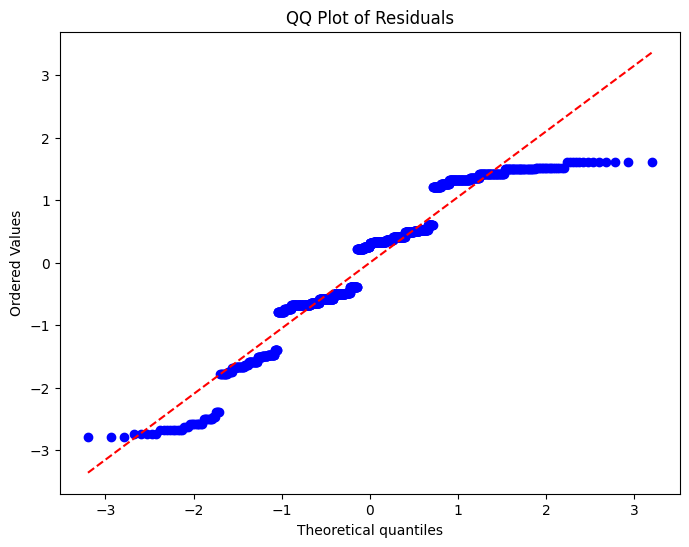

In [ ]:
from scipy.stats import shapiro, levene
import scipy.stats as stats

# Get a random sample of 1000 observations from df_anova to get a accurate result in shaprio and levene test
sample_df = df_anova.sample(n=1000, random_state=42)

# Get residuals
residuals = []
for _, group in sample_df.groupby('Date'):
    residuals.extend(group['Rating'] - group['Rating'].mean())

# QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.get_lines()[1].set_linestyle('--')  # add a dashed line to compare against normal distribution
ax.set_title('QQ Plot of Residuals')
plt.show();

In [ ]:
# Shapiro-Wilk test for normality
_, shapiro_p_value = shapiro(residuals)
if shapiro_p_value > alpha:
    print("Residuals are normally distributed (normality assumption is met).")
else:
    print("Residuals are not normally distributed (normality assumption may be violated).")

Residuals are not normally distributed (normality assumption may be violated).


The variances are approximately lineair in the QQ-plot, even though the gaps between the groups suggest deviations in normality. Therefore, there is evidence to suggest that this assumption of ANOVA is not violated and that the residuals follow a normal distribution. The Shapiro test says otherwise, meaning this violation is violated.

**Homogeneity of variances assumption check:**

In [ ]:
# Levene's test for homogeneity of variances
levene_statistic, levene_p_value = levene(*[group['Rating'] for _, group in sample_df.groupby('Date')])
if levene_p_value > alpha:
    print("Variances of residuals are approximately equal across all groups (homogeneity of variances assumption is met).")
else:
    print("Variances of residuals are not equal across all groups (homogeneity of variances assumption may be violated).")

C:\Users\SJYHa\AppData\Local\Temp\ipykernel_7124\865908296.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene_statistic, levene_p_value = levene(*[group['Rating'] for _, group in sample_df.groupby('Date')])


Variances of residuals are approximately equal across all groups (homogeneity of variances assumption is met).


As the residuals assumption is violated, the kruskal wallis test is needed to further investigate the validity of ANOVA results:

In [ ]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis test
kruskal_statistic, kruskal_p_value = kruskal(*[group['Rating'] for _, group in df_anova.groupby('Date')])

print("Kruskal-Wallis Statistic:", kruskal_statistic)
print("P-value:", kruskal_p_value)

alpha = 0.05 # Set confidence level at 95%
if kruskal_p_value < alpha:
    print("Reject the null hypothesis. There is enough evidence to suggest that there are significant differences between the groups. Therefore, there IS enough evidence to suggest month of the year has significant correlation with avg. rating.")
else:
    print("Fail to reject the null hypothesis. There IS NOT enough evidence to suggest that there are significant differences between the groups across months of the year. Therefore, there is NOT enough evidence to suggest month of the year has significant correlation with avg. rating.")


Kruskal-Wallis Statistic: 170.37403415073075
P-value: 9.882102521947245e-31
Reject the null hypothesis. There is enough evidence to suggest that there are significant differences between the groups. Therefore, there IS enough evidence to suggest month of the year has significant correlation with avg. rating.


C:\Users\SJYHa\AppData\Local\Temp\ipykernel_7124\1833443547.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kruskal_statistic, kruskal_p_value = kruskal(*[group['Rating'] for _, group in df_anova.groupby('Date')])


### Genre association with ratings:

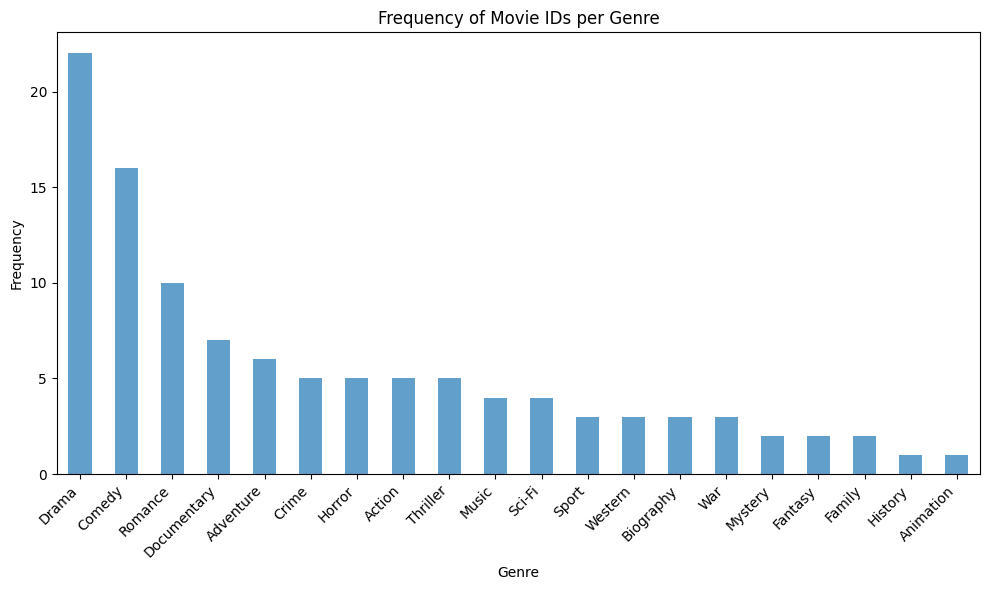

In [ ]:
genres_list = sampled_df['genres'].explode().dropna()

# Count the frequencies of each genre
genre_counts = genres_list.value_counts()

# Plot the frequencies
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Frequency of Movie IDs per Genre')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show();

In [ ]:
# Print the result
print("The genre with the maximum frequency is:", genre_counts.idxmax())

The genre with the maximum frequency is: Drama


## Handle null values:

Already handled in the joining.ipynb file. There are no null values in the Netflix Prize Dataset to handle.